<a href="https://colab.research.google.com/github/kridtapon/Breaker-Block-Strategy/blob/main/Breaker_Block_Strategy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install vectorbt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.6/527.6 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.7/295.7 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.7/119.7 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 16.2 MB/s eta 0:00:00


In [ ]:
pip install --upgrade yfinance

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import vectorbt as vbt

# Download the data
symbol = 'COR'
start_date = '2019-01-01'
end_date = '2025-01-01'
df = yf.download(symbol, start=start_date, end=end_date)
df.columns = ['Close', 'High', 'Low', 'Open', 'Volume']

# Calculate rolling highs/lows to simulate structure levels
df['Day_High'] = df['High'].rolling(window=20).max()
df['Day_Low'] = df['Low'].rolling(window=20).min()

# Break of Market Structure (BMS) = price breaks previous high or low significantly
df['BMS_Up'] = (df['Close'] > df['Day_High'].shift(10))
df['BMS_Down'] = (df['Close'] < df['Day_Low'].shift(10))

# Identify Breaker Block Candle (the last candle before breakout)
df['Breaker_Block_Up'] = df['Low'].shift(10)  # For bullish break
df['Breaker_Block_Down'] = df['High'].shift(10)  # For bearish break

# Retest Condition: Price returns to breaker block area
df['Retest_Up'] = (df['Low'] <= df['Breaker_Block_Up']) & df['BMS_Up'].shift(10)
df['Retest_Down'] = (df['High'] >= df['Breaker_Block_Down']) & df['BMS_Down'].shift(10)

# Rejection: Basic rejection candle (bullish pin bar)
df['Bull_Reject'] = (df['Close'] > df['Open']) & ((df['Low'] < df['Low'].shift(10)) & (df['Close'] > df['Open'].shift(10)))
df['Bear_Reject'] = (df['Close'] < df['Open']) & ((df['High'] > df['High'].shift(10)) & (df['Close'] < df['Open'].shift(10)))

# Filter the date range
df = df[(df.index.year >= 2020) & (df.index.year <= 2025)]

# Entry logic
df['Entry'] = (df['Retest_Up'] | df['Bear_Reject'])

# Exit logic
df['Exit'] = (df['Bull_Reject'] | df['Retest_Down'])

# Backtest using vectorbt
portfolio = vbt.Portfolio.from_signals(
    close=df['Close'],
    entries=df['Entry'],
    exits=df['Exit'],
    init_cash=100_000,
    fees=0.001,
    slippage=0.002,
    freq='D'
)

# Show performance
print(portfolio.stats())
portfolio.plot().show()


[*********************100%***********************]  1 of 1 completed


Start                         2020-01-02 00:00:00
End                           2024-12-31 00:00:00
Period                         1258 days 00:00:00
Start Value                              100000.0
End Value                           179839.695358
Total Return [%]                        79.839695
Benchmark Return [%]                   181.901896
Max Gross Exposure [%]                      100.0
Total Fees Paid                       6433.760126
Max Drawdown [%]                        17.903032
Max Drawdown Duration           338 days 00:00:00
Total Trades                                   25
Total Closed Trades                            24
Total Open Trades                               1
Open Trade PnL                        -7589.74886
Win Rate [%]                                 62.5
Best Trade [%]                           26.82847
Worst Trade [%]                         -6.667589
Avg Winning Trade [%]                    5.744361
Avg Losing Trade [%]                     -1.99679


In [ ]:
pip install mplfinance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 3.8 MB/s eta 0:00:00


[*********************100%***********************]  1 of 1 completed


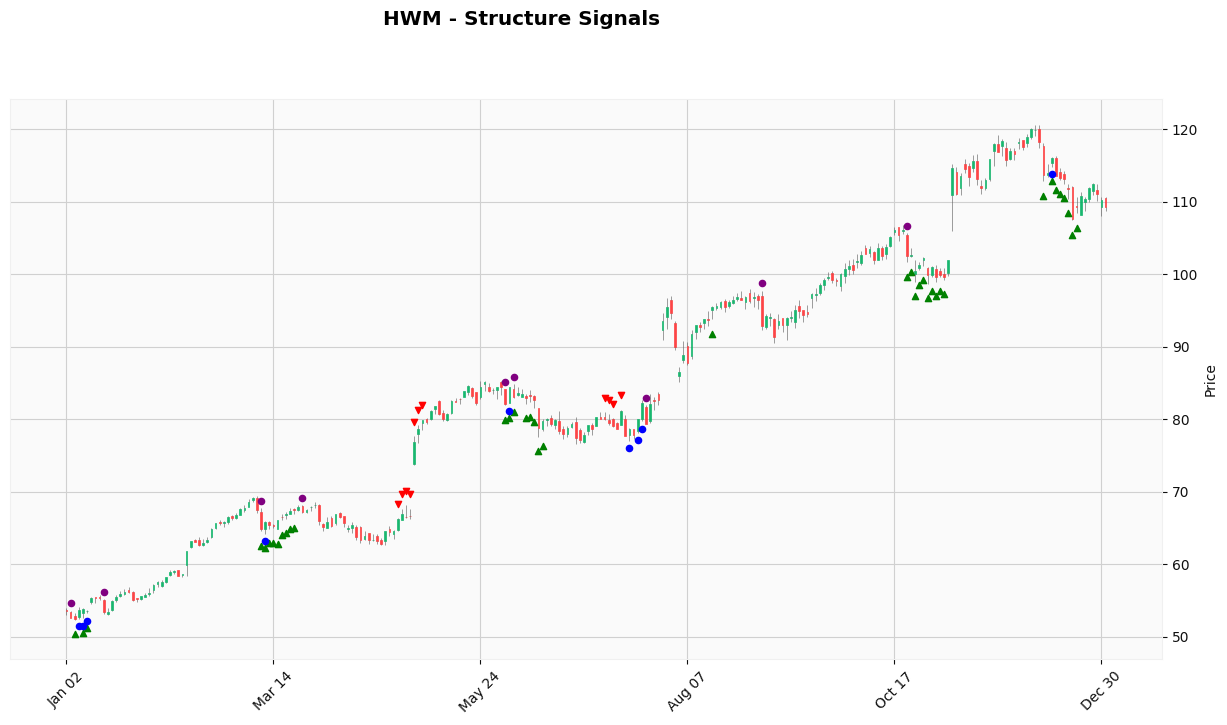

Legend:
🔼 Green Up Arrow: Retest Up (Price retested prior Breaker Block after bullish BMS)
🔽 Red Down Arrow: Retest Down (Price retested prior Breaker Block after bearish BMS)
🔵 Blue Circle: Bullish Rejection Candle (Suggests continuation or reversal up)
🟣 Purple Circle: Bearish Rejection Candle (Suggests continuation or reversal down)


In [ ]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import mplfinance as mpf

# Download data
symbol = 'HWM'
start_date = '2023-01-01'
end_date = '2025-01-01'
df = yf.download(symbol, start=start_date, end=end_date)
df.columns = ['Close', 'High', 'Low', 'Open', 'Volume']

# Calculate rolling highs/lows
df['Day_High'] = df['High'].rolling(window=20).max()
df['Day_Low'] = df['Low'].rolling(window=20).min()

# Break of Market Structure (BMS)
df['BMS_Up'] = (df['Close'] > df['Day_High'].shift(10))
df['BMS_Down'] = (df['Close'] < df['Day_Low'].shift(10))

# Breaker Block Candle levels
df['Breaker_Block_Up'] = df['Low'].shift(10)
df['Breaker_Block_Down'] = df['High'].shift(10)

# Retest Conditions
df['Retest_Up'] = (df['Low'] <= df['Breaker_Block_Up']) & df['BMS_Up'].shift(10)
df['Retest_Down'] = (df['High'] >= df['Breaker_Block_Down']) & df['BMS_Down'].shift(10)

# Rejection candles
df['Bull_Reject'] = (df['Close'] > df['Open']) & ((df['Low'] < df['Low'].shift(10)) & (df['Close'] > df['Open'].shift(10)))
df['Bear_Reject'] = (df['Close'] < df['Open']) & ((df['High'] > df['High'].shift(10)) & (df['Close'] < df['Open'].shift(10)))

# Create markers only where signals are True
df['Retest_Up_marker'] = df['Low'] - 2
df['Retest_Up_marker'] = df['Retest_Up_marker'].where(df['Retest_Up'])

df['Retest_Down_marker'] = df['High'] + 2
df['Retest_Down_marker'] = df['Retest_Down_marker'].where(df['Retest_Down'])

df['Bull_Reject_marker'] = df['Low'] - 1
df['Bull_Reject_marker'] = df['Bull_Reject_marker'].where(df['Bull_Reject'])

df['Bear_Reject_marker'] = df['High'] + 1
df['Bear_Reject_marker'] = df['Bear_Reject_marker'].where(df['Bear_Reject'])

# Filter the date range
df = df[(df.index.year >= 2024) & (df.index.year <= 2025)]

# Build a DataFrame for mplfinance markers
apds = [
    mpf.make_addplot(df['Retest_Up_marker'], type='scatter', markersize=20, marker='^', color='green', panel=0),
    mpf.make_addplot(df['Retest_Down_marker'], type='scatter', markersize=20, marker='v', color='red', panel=0),
    mpf.make_addplot(df['Bull_Reject_marker'], type='scatter', markersize=20, marker='o', color='blue', panel=0),
    mpf.make_addplot(df['Bear_Reject_marker'], type='scatter', markersize=20, marker='o', color='purple', panel=0),
]

# Plot with mplfinance
mpf.plot(df, type='candle', volume=False, style='yahoo', addplot=apds, title=f"{symbol} - Structure Signals", figratio=(16,9), figsize=(16,8))

print("Legend:")
print("🔼 Green Up Arrow: Retest Up (Price retested prior Breaker Block after bullish BMS)")
print("🔽 Red Down Arrow: Retest Down (Price retested prior Breaker Block after bearish BMS)")
print("🔵 Blue Circle: Bullish Rejection Candle (Suggests continuation or reversal up)")
print("🟣 Purple Circle: Bearish Rejection Candle (Suggests continuation or reversal down)")

[*********************100%***********************]  1 of 1 completed


Best Parameters: Day_High_Window=12, Day_Low_Window=18, Shift=21


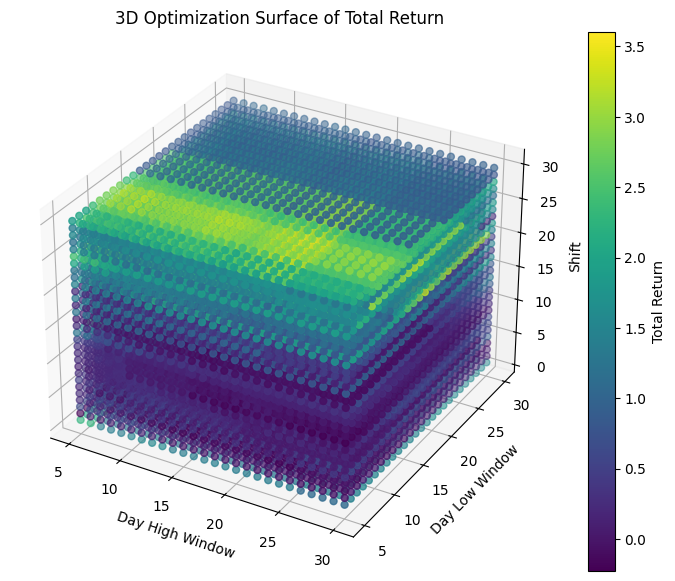

Start                         2020-01-02 00:00:00
End                           2024-12-31 00:00:00
Period                         1258 days 00:00:00
Start Value                              100000.0
End Value                            460293.02292
Total Return [%]                       360.293023
Benchmark Return [%]                   250.578057
Max Gross Exposure [%]                      100.0
Total Fees Paid                       6398.792459
Max Drawdown [%]                        48.391818
Max Drawdown Duration           184 days 00:00:00
Total Trades                                   20
Total Closed Trades                            19
Total Open Trades                               1
Open Trade PnL                       67917.614531
Win Rate [%]                            78.947368
Best Trade [%]                            72.4008
Worst Trade [%]                        -38.987831
Avg Winning Trade [%]                   15.234039
Avg Losing Trade [%]                    -11.24866


In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import vectorbt as vbt
from itertools import product

# Download the data
symbol = 'HWM'
start_date = '2019-01-01'
end_date = '2025-01-01'
df = yf.download(symbol, start=start_date, end=end_date)
df.columns = ['Close', 'High', 'Low', 'Open', 'Volume']

# Parameter ranges
day_high_window_range = range(5, 31)
day_low_window_range = range(5, 31)
shift_range = range(1, 31)

# Generate parameter combinations
param_combinations = list(product(day_high_window_range, day_low_window_range, shift_range))

# Store results
entries_dict = {}
exits_dict = {}

for high_win, low_win, shift in param_combinations:
    temp_df = df.copy()

    temp_df['Day_High'] = temp_df['High'].rolling(window=high_win).max()
    temp_df['Day_Low'] = temp_df['Low'].rolling(window=low_win).min()

    temp_df['BMS_Up'] = temp_df['Close'] > temp_df['Day_High'].shift(shift)
    temp_df['BMS_Down'] = temp_df['Close'] < temp_df['Day_Low'].shift(shift)

    temp_df['Breaker_Block_Up'] = temp_df['Low'].shift(shift)
    temp_df['Breaker_Block_Down'] = temp_df['High'].shift(shift)

    temp_df['Retest_Up'] = (temp_df['Low'] <= temp_df['Breaker_Block_Up']) & temp_df['BMS_Up'].shift(shift)
    temp_df['Retest_Down'] = (temp_df['High'] >= temp_df['Breaker_Block_Down']) & temp_df['BMS_Down'].shift(shift)

    temp_df['Bull_Reject'] = (temp_df['Close'] > temp_df['Open']) & \
                             ((temp_df['Low'] < temp_df['Low'].shift(shift)) & (temp_df['Close'] > temp_df['Open'].shift(shift)))
    temp_df['Bear_Reject'] = (temp_df['Close'] < temp_df['Open']) & \
                             ((temp_df['High'] > temp_df['High'].shift(shift)) & (temp_df['Close'] < temp_df['Open'].shift(shift)))

    temp_df = temp_df[(temp_df.index.year >= 2020) & (temp_df.index.year <= 2025)]

    entry = (temp_df['Retest_Up'] | temp_df['Bear_Reject'])
    exit = (temp_df['Bull_Reject'] | temp_df['Retest_Down'])

    key = (high_win, low_win, shift)
    entries_dict[key] = entry
    exits_dict[key] = exit

# Convert to DataFrames for vectorbt
entries_df = pd.DataFrame(entries_dict)
exits_df = pd.DataFrame(exits_dict)

# Backtest
portfolio = vbt.Portfolio.from_signals(
    close=df['Close'].loc[entries_df.index],
    entries=entries_df,
    exits=exits_df,
    init_cash=100_000,
    fees=0.001,
    slippage=0.002,
    freq='D'
)

# Find the best performing parameter combination
performance = portfolio.total_return()
best_key = performance.idxmax()
print(f"Best Parameters: Day_High_Window={best_key[0]}, Day_Low_Window={best_key[1]}, Shift={best_key[2]}")

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Prepare data for 3D plot
returns = performance.copy()
params = np.array(returns.index.tolist())  # shape (n, 3)
day_high_window_vals = params[:, 0]
day_low_window_vals = params[:, 1]
shift_vals = params[:, 2]
returns_vals = returns.values

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(day_high_window_vals, day_low_window_vals, shift_vals, c=returns_vals, cmap='viridis', s=25)

# Label axes
ax.set_xlabel('Day High Window')
ax.set_ylabel('Day Low Window')
ax.set_zlabel('Shift')
fig.colorbar(sc, label='Total Return')

plt.title("3D Optimization Surface of Total Return")
plt.show()

print(portfolio[best_key].stats())

# Plot the best portfolio
portfolio[best_key].plot().show()
